Layer: 4
T =  1800


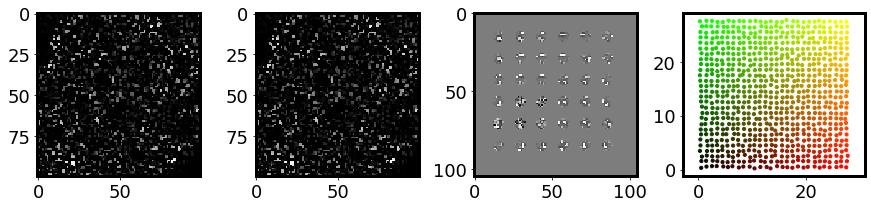

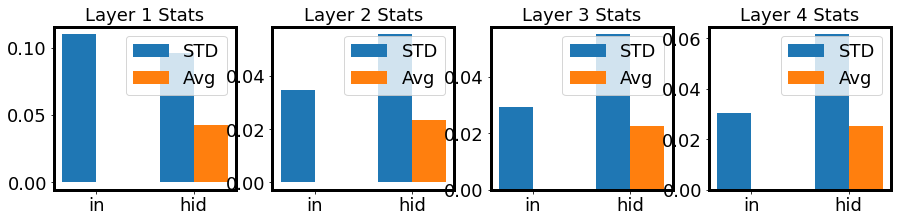

Epoch 1/10
1875/1875 [==============================] - 60s 31ms/step - loss: 0.4705 - accuracy: 0.8384
Epoch 2/10
1875/1875 [==============================] - 57s 31ms/step - loss: 0.3522 - accuracy: 0.8745
Epoch 3/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.3241 - accuracy: 0.8840
Epoch 4/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.3064 - accuracy: 0.8907
Epoch 5/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.2940 - accuracy: 0.8947
Epoch 6/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.2834 - accuracy: 0.8984
Epoch 7/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.2769 - accuracy: 0.9006
Epoch 8/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.2697 - accuracy: 0.9020
Epoch 9/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.2644 - accuracy: 0.9059
Epoch 10/10
1875/1875 [==============================] - 57s 30m

ValueError: ignored

In [2]:
%tensorflow_version 2.x
%matplotlib inline

!pip install import_ipynb # Should allow other jupiter notebooks to be loaded using import
!pip install tfa-nightly # Needed to get tensorflow image addons working (2.7.1 works)

# -*- coding: utf-8 -*-
"""
Created on Mon Nov/19/2020

@author: James Ryland

Experiment 1:
    In this set of simulations we are just going to check if a modestly deep
(3-5) module networks can learn to classify objects without any deep gradient
descent or supervised learning. We will also test if the performance when
the unsupervised learning is treated as a pre-training step before deep
supervised gradient descent.

Experiment 2:
    In this experiment we will examin how specialized the units in the ProtoICL
network become by comparing its unit deletion curves to its unit deletion curves
with the addition of a new fully connected layer (w/t) training or a rotation
matrix.

Experiment 3:
    In this experiment we will examin if the units develope a topology organized
by category in the top layer of the network.

Notes:  When used solely as a pre-training step ICL learning may just be an
        inefficient method. It's practical utility is probably more so in 
        making models which compare better to cortical mechanisms 


To run several demonstrations see the instructions at the end of the file

"""

import import_ipynb

import ArborLayer
import SimpleICLayer
import SimpleComplexICLayer


from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from   tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow.keras as keras
import numpy as np
from IPython.display import clear_output

from scipy.stats import ortho_group
from scipy.ndimage import label as RegionLabel
import gc
import scipy.stats as stats

from datetime import date
from datetime import datetime

#import seaborn as sns

""" Non-multiple view data-sets

    For these dataset we will be using a simple temporal training environment,
    but we may increase the complexity a bit later

"""

# Style for plotting
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

# Setup some basic font size thingies
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes' , linewidth =3)
plt.rc('lines', linewidth =3)
plt.rc('lines', markersize =10)

# Quick little function for getting prettier significant digits
def sigdigN(a, n):
    exp = np.floor(np.log10(a))
    return np.round(a, (-exp+n).astype(int)) 

def fileBase(quickNote):
    today = date.today()
    now = datetime.now()
    info = today.strftime("%b%d%y") +"_"+ now.strftime("%H%M")+"_"+quickNote
    return "MNISTF"+info

# Very simple class that scales an entire layer by the variance and mean of the
# entire layer. 
class ScalerNorm(layers.Layer):
    def __init__(self, beta = .01):
        super().__init__()
        self.beta = .01
        self.mean = self.add_weight(shape=[], initializer='zeros', trainable=False)
        self.STD  = self.add_weight(shape=[], initializer='ones', trainable=False)

    def call(x, training=False):
        if training:
            self.mean.assign( self.mean*(1-self.beta) + tf.reduce_mean(x)*self.beta )
            self.STD.assign ( self.STD*(1-self.beta) + tf.math.reduce_std(x)*self.beta )
        return (x-self.mean)/self.STD


def ScrambleShift(Dataset, offLimit):

    inShape = Dataset.shape

    # Padd the dataset to avoid edge artifacts!
    noPad = [0,0]
    padX = [inShape[1],inShape[1]]
    padY = [inShape[2],inShape[2]]
    Dataset = tf.pad(Dataset, [noPad, padX, padY, noPad])
    
    # Account for padding
    offLimit = offLimit/float(inShape[1])/3

    # Setup the offshapes
    offXY = np.random.uniform(-offLimit,offLimit, size=[inShape[0],2]).astype(np.float32)

    # Offest the data
    DatOffset = tf.image.extract_glimpse(Dataset, inShape[1:3], offXY) #, normalized=True)

    return DatOffset


##   EXPERIMENT (1)  PERFORMANCE          EXPERIMENT (1)  PERFORMANCE
#-------------------------------------------------------------------------------
class ICLNet_MNIST(tf.keras.Model):

    def __init__(self, name=None, enableFullBackprop = False, deepPreTrain=False, sizeSettings="narrow", latSettings="map", GC=True, useComplex=False, useAxon=False):
        super().__init__(name=name)

        # Experimental conditions
        self.enableFullBackprop = enableFullBackprop

        # Current training state
        self.preTrain = True
        self.preTrainLayer = 0 
        self.deepPreTrain = deepPreTrain
        self.exp2 = False
        self.exp3 = False
        self.exp2Train = False
        self.rotation = False
        self.transGen = False

        # Pre processing
        self.cc0 = SimpleICLayer.WindNormLayer(6, mult=4)

        # Gives better results but may be messing up experiment2
        self.ccIC = SimpleICLayer.WindNormLayer(6, mult=1) #mult=2 worked better for optimal settings
        # TEst if this is affecting experiment 2
        #print("Testing SUBOPTIMAL ccIC")
        #self.ccIC = SimpleICLayer.CenterSurround(1, 4)
        
        self.Norm0 = layers.BatchNormalization(axis=[1,2], center=False, trainable=True)
        self.Norm1 = layers.BatchNormalization(axis=[1,2], center=False, trainable=True)
        self.Norm2 = layers.BatchNormalization(axis=[1,2], center=False, trainable=True)
        self.Norm3 = layers.BatchNormalization(axis=[1,2], center=False, trainable=True)
        self.Norm4 = layers.BatchNormalization(axis=[1,2], center=False, trainable=True)
        self.NormLS = [self.Norm1, self.Norm2, self.Norm3, self.Norm4]

        # Optimal lateral interactions and Depths
        self.lat, self.depth, self.fRate = [],[],[]
        if latSettings=="optimal":
            self.lat  = [[.6, 2], [.6, 2], [.6, 2],  [.6, 2]] 
            self.depth = [6*6, 6*6, 6*6, 6*6]  # 6x6 seems better
            self.fRate = [.3, .3, .3, .3]

            # use a different multiplier for this normalization layer
            self.ccIC = SimpleICLayer.WindNormLayer(6, mult=2) 

        elif latSettings=="map": # Strong map characteristics
            self.lat  = [[.6, 2]  , [.75, 2.2], [.8, 2.4],  [1.0, 2.6]] 
            self.depth = [6*6, 12*12, 14*14, 16*16]
            self.fRate = [.5, 1.5, 1.5, 1.5]
        else:
            print("WARNING: hyperparameters not set")

        if not GC:
            self.ccIC = SimpleICLayer.CenterSurround(1, 4)
            self.fRate = [.3, .3, .3, .3]

        self.rez = []
        if sizeSettings=="narrow":
            self.rez = [100, 80, 60, 40]
        elif sizeSettings=="same":
            self.rez = [100, 100, 100, 100] 
        else:
            print("WARNING: rez not set")

        self.ICL1, self.ICL2, self.ICL3, self.ICL4 = [],[],[],[]
        self.ICL_LS = []


        if not useComplex:
            self.ICL1 = SimpleICLayer.ProtoICLayer(self.rez[0], self.depth[0], lat=self.lat[0], latBias=[1, 1.6], fRate=self.fRate[0], nWeight=0, axonLearn=useAxon, axRate=.1)
            self.ICL2 = SimpleICLayer.ProtoICLayer(self.rez[1], self.depth[1], lat=self.lat[1], latBias=[1, 1.6], fRate=self.fRate[1], nWeight=0, axonLearn=useAxon, axRate=.1)
            self.ICL3 = SimpleICLayer.ProtoICLayer(self.rez[2], self.depth[2], lat=self.lat[2], latBias=[1, 1.6], fRate=self.fRate[2], nWeight=0, axonLearn=useAxon, axRate=.1)
            self.ICL4 = SimpleICLayer.ProtoICLayer(self.rez[3], self.depth[3], lat=self.lat[3], latBias=[1, 1.6], fRate=self.fRate[3], nWeight=0, axonLearn=useAxon, axRate=.1)
            self.ICL_LS = [self.ICL1, self.ICL2, self.ICL3, self.ICL4]
        else:
            self.ICL1 = SimpleComplexICLayer.ProtoICLayer(self.rez[0], self.depth[0], lat=self.lat[0], latBias=[1, 1.6], fRate=self.fRate[0], nWeight=0)
            self.ICL2 = SimpleComplexICLayer.ProtoICLayer(self.rez[1], self.depth[1], lat=self.lat[1], latBias=[1, 1.6], fRate=self.fRate[1], nWeight=0)
            self.ICL3 = SimpleComplexICLayer.ProtoICLayer(self.rez[2], self.depth[2], lat=self.lat[2], latBias=[1, 1.6], fRate=self.fRate[2], nWeight=0)
            self.ICL4 = SimpleComplexICLayer.ProtoICLayer(self.rez[3], self.depth[3], lat=self.lat[3], latBias=[1, 1.6], fRate=self.fRate[3], nWeight=0)
            self.ICL_LS = [self.ICL1, self.ICL2, self.ICL3, self.ICL4]

        self.Flat = layers.Flatten()
        self.Dense1 = layers.Dense(10, activation='relu')
        
        # Special layers for EXP2
        self.outRez = 40
        self.mask   = np.ones( (1,self.outRez*self.outRez) ) # [batch, dense]
        #self.rotationMatrix = np.ones( (self.outRez*self.outRez,self.outRez*self.outRez))
        self.rotationMatrix = ortho_group.rvs(dim=self.outRez*self.outRez).astype(np.float32)
        self.DenseMid = layers.Dense(self.outRez*self.outRez, activation=None, use_bias=False)
        #self.DenseExp = layers.Dense(10, activation='relu', use_bias=False)
        self.DenseExp = layers.Dense(10, activation=None, use_bias=True)
        
        #self.Drop = layers.Dropout(.7)

    def exp_setup(self, exp2=False, exp3=False, activeNum=0, rotation=False, middleDense=False, stopMidGrad=False):
        # set the path for the call function
        self.exp2      = exp2
        self.exp3      = exp3
        self.rotation  = rotation
        self.middleDense = middleDense
        self.stopMidGrad = stopMidGrad
        
        # This will be used in the unit deletion experiments
        self.mask   = np.zeros( (1,self.outRez*self.outRez) ) # [batch, dense]

        # sprinkle some non-zero values
        sprinkles = np.random.choice(self.outRez*self.outRez, size=[activeNum])
        self.mask[0,sprinkles] = 1
        if activeNum==0:
            self.mask = np.ones( (1,self.outRez*self.outRez) )
        
        # set/reset random rotation matrix
        #if self.rotation:
        #    self.rotationMatrix = ortho_group.rvs(dim=self.outRez*self.outRez)

        # Freeze all of the layers
        self.Norm1.trainable = False
        self.Norm2.trainable = False
        self.Norm3.trainable = False
        self.Norm4.trainable = False
        self.ICL1.trainable = False
        self.ICL2.trainable = False
        self.ICL3.trainable = False
        self.ICL4.trainable = False
        self.Dense1.trainable = False
        

    def call(self, x, training=None):
        
            
        # Sharpe and normalize (centered boxnorm Im-mean/max(abs(Im-mean)))
        x = SimpleICLayer.ItemBoxNorm(x)

        # Putting this here may eliminate center baias to an extent?
        if self.transGen and not self.preTrain:
            #x = ScrambleShift(x, 16)
            x = ScrambleShift(x, 31)

        # First local gc normalization
        x = self.cc0(x)

        if self.preTrain and not self.deepPreTrain: 

            for i in range(0, self.preTrainLayer+1):
                x = self.ICL_LS[i] (x, training=i==self.preTrainLayer)
                x = self.ccIC(x)
                #x = SimpleICLayer.ItemBoxNorm(x)
            
        elif self.exp2 or self.exp3: # Deletion curve training or map visualization

            for i in range(0, self.preTrainLayer+1):
                x = self.ICL_LS[i] (x, training=False)
                x = self.ccIC(x) 
            
            if self.exp2:
                x = self.Flat (x)

                if self.rotation:
                    x = tf.matmul(x,self.rotationMatrix)

                x = tf.stop_gradient(x)

                # Just output the image

                #x = x * self.mask
                #x = self.DenseExp(x)

        else: # Normal classification training
            for i in range(0, self.preTrainLayer+1):
                x = self.ICL_LS[i] (x, training=False)
                x = self.ccIC(x)
                #x = SimpleICLayer.ItemBoxNorm(x)
            
            x = self.Norm4(x, training=training)

            x = self.Flat (x)
            if not self.enableFullBackprop:
                x = tf.stop_gradient(x)
            x = self.Dense1(x)
            
        return x

# class to track layer stats for debugging deep ProtoICL networks
class LayerStats: 
    def __init__(self, ICL, layerName, beta=.01):
        self.ICL = ICL
        self.beta   = beta
        self.layerName = layerName
        self.inSTD  = 0
        self.hidSTD = 0
        self.inAvg  = 0
        self.hidAvg = 0
        
    def runMean(self, mean, newVal):
        return mean*(1-self.beta) + newVal*(self.beta)
    def update(self):
        self.inSTD  = self.runMean(self.inSTD,  tf.math.reduce_std(self.ICL.last_In))
        self.hidSTD = self.runMean(self.hidSTD, tf.math.reduce_std(self.ICL.last_Hid))
        self.inAvg  = self.runMean(self.inAvg,  tf.math.reduce_mean(self.ICL.last_In))
        self.hidAvg = self.runMean(self.hidAvg, tf.math.reduce_mean(self.ICL.last_Hid))
        
    def graphStats(self, ax):
        ax.cla()
        x_pos = np.arange(2)
        width = 0.35 
        ax.bar( x_pos      , [self.inSTD, self.hidSTD], width, label="STD")
        ax.bar( x_pos+width, [self.inAvg, self.hidAvg], width, label="Avg" )
        ax.set_title("Layer "+ str(self.layerName) +" Stats")
        ax.set_xticks(x_pos+width/2)
        ax.set_xticklabels(["in", "hid"])
        ax.legend()



# Quick little test for a shallow ProtoICL net...
def EXP1_MNISTF_Performance( supLearn = False, fullPreTrain=True, classTrain="full", latSettings="map", sizeSettings="narrow", GC=True, useComplex=False, useAxon=False):

    fashion_mnist = keras.datasets.fashion_mnist
    labelNames = [  "top", "trouser", "pullover", "dress", "coat",
	                "sandal", "shirt", "sneaker", "bag", "ankle boot"]
    
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    train_images = train_images[:,:,:,np.newaxis]
    test_images = test_images[:,:,:,np.newaxis]

    train_labels = keras.utils.to_categorical(train_labels, 10)
    test_labels = keras.utils.to_categorical(test_labels, 10)

    # Normalize images
    train_images = (train_images/255.0).astype(np.float32)
    test_images = (test_images/255.0).astype(np.float32)

    # Create ICL net for MNIST type datasets
    model = ICLNet_MNIST(enableFullBackprop=supLearn, deepPreTrain=False, latSettings=latSettings, sizeSettings=sizeSettings, GC=GC, useComplex=useComplex, useAxon=useAxon)
    
    # Setup temporal augmentation (I think these are good first layer settings!)
    batch = 20
    episodeLength = 10
    batch = 10

    Picker = SimpleICLayer.ItemPicker(batch, train_labels, 5, 10)

    Aug = SimpleICLayer.TemporalAugmentLayer(batch, episodeLength, shiftSpeed=.4, phiSpeed=.4, 
                                            speedMultiplier = 1.0, momentum=.99, changeEachStep=True)
    
    lRun = 1
    lBeta = .01
    lay1Stats = LayerStats(model.ICL1, 1)
    lay2Stats = LayerStats(model.ICL2, 2)
    lay3Stats = LayerStats(model.ICL3, 3)
    lay4Stats = LayerStats(model.ICL4, 4)
    
    layStats = [lay1Stats, lay2Stats, lay3Stats, lay4Stats]
    dispMods = [model.ICL1, model.ICL2, model.ICL3, model.ICL4 ]

    # Pretraining Loop
    model.preTrain = True

    # Number of pre-training steps per layer

    laySteps = 2000
    if useComplex:
        laySteps = 3000
    if not fullPreTrain:
        laySteps = 10 

    for l in range(0,4):
        
        for i in range(0, laySteps):
            
            model.preTrainLayer = l
            dispMod = dispMods[np.minimum(l,3)]

            # Pick and augment input data
            #picks = np.random.choice(train_images.shape[0], size=[batch])
            picks = Picker()
            in_imRaw = train_images[picks,:,:,:]
            in_im = Aug(in_imRaw)
            
            # Run the model on the batch
            out_im = model(in_im, training=False)
            
            # Get statistics
            layStats[np.minimum(3,model.preTrainLayer)].update()
            
            if np.mod(i,200)==0:
                
                clear_output()
                
                print("Layer:", model.preTrainLayer+1)
                print("T = ", i)
                #print(" * L( t =",i,") = ", lRun)
                fig = plt.figure(figsize=[15,3])
                ax = fig.add_subplot(1, 4, 1)
                ax.imshow(np.squeeze(dispMod.last_Hid[0,:,:,:]), cmap='gray', interpolation='nearest')
                
                ax = fig.add_subplot(1, 4, 2)
                dispIm = dispMod.last_Hid.numpy()[0,:,:,0]
                ax.imshow(np.squeeze(dispIm), cmap='gray', interpolation='nearest')

                ax = fig.add_subplot(1, 4, 3)
                dispIm = dispMod.Arb.projectWeights(sampleInterval=15, projectInterval=14, center=True) 
                ax.imshow(np.squeeze(dispIm), cmap='gray', interpolation='nearest')
                
                ax = fig.add_subplot(1, 4, 4)
                dispIm = ArborLayer.PlotArborsXY(ax, model.ICL1.Arb, s=10 )

                fig2 = plt.figure(figsize=[15,3])
                lay1Stats.graphStats(fig2.add_subplot(1,4,1))
                lay2Stats.graphStats(fig2.add_subplot(1,4,2))
                lay3Stats.graphStats(fig2.add_subplot(1,4,3))
                lay4Stats.graphStats(fig2.add_subplot(1,4,4))
                
                plt.pause(.1)

    # Turn off the pre-traing path in model call function
    model.preTrain = False

    # Consider doing a quick non-deep classification training
    # This would keep it from destroying finer structure in the
    # Top layer

    # compile the model for either shallow classification training 
    # or full supervised classification training
    # SGD may not be the best optimizer... play around with this
    #optimizer = tf.keras.optimizers.SGD(learning_rate=.05, momentum=.0)
    optimizer = tf.keras.optimizers.Adam(learning_rate=.0001)  # this is just an experiment... # .00001 may have worked better give it a try sometimes
    #optimizer = tf.keras.optimizers.RMSprop(learning_rate=.05)
    model.compile(  optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              run_eagerly=False,
              metrics=['accuracy'])

    best_acc = 0

    # Train the model on the supplied training data without modification
    #   - may want to try some augmentation here to see if ICL net can handle
    #     better
    #   - between 3 & 15 epoch appears to work well enough for our purposes
    supEpochs = 10
    supBatch = 32

    if   classTrain=="full":
        model.fit(train_images, train_labels, epochs=supEpochs, batch_size=supBatch)
    elif classTrain=="short":
        supEpochs = 5
        model.fit(train_images, train_labels, epochs=supEpochs, batch_size=supBatch)
    elif classTrain=="none":
        pass

    # Find the accurcacy of the model on the test dataset
    test_acc = 0
    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
    print('\nTest accuracy:', test_acc)
    
    # Get the model predictions for building a detailed classification report 
    test_pred = model.predict(test_images)

    # Print up a classification report
    classReport = classification_report(np.argmax(test_pred,axis=-1), np.argmax(test_labels,axis=-1), target_names=labelNames)
    print("\n[INFO] evaluating network...")
    print(classReport)

    #   Save the results of EXP1 and Record Results:
    #--------------------------------------------------
    fileName = fileBaseStr +".txt"
    file = open( fileName,"w")
    text = ""
    text = text + "NOTE:\n"
    text = text + "\t" +note+ "\n\n"
    text = text + "MODEL INFO:  MNIST\n"
    text = text + "----------------------------\n"
    text = text + "          E/I Radius: "+str(model.lat)+"\n"
    text = text + "       Window Depths: "+str(model.depth)+"\n"
    text = text + "        Feature Rate: "+str(model.fRate)+"\n"
    text = text + "           layer rez: "+str(model.rez)+"\n"
    text = text + "    Supervised Learn: "+str(supLearn)+"\n"
    text = text + "   Supervised Epochs: "+str(supEpochs)+"\n"
    text = text + "    Supervized Batch: "+str(supBatch)+"\n"
    
    text = text + "\n\nEXPERIMENT 1 RESULTS:  MNIST\n"
    text = text + "----------------------------\n\n"
    text = text + "Test Accuracy: " + str( np.round( test_acc*100, 2)) + "% \n\n"
    text = text + "Full Report: \n"
    text = text + classReport
    file.writelines(text) 
    file.close()

    return model, fileName

# These need to be set before calling the experiment functions
#note      = "Testing The Training Function."
#quickNote = "TestTrain"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance()




##   EXPERIMENT (2)  SPECIAL            EXPERIMENT (2)  SPECIAL 
#-------------------------------------------------------------------------------


# A quick plot for the results of the experiment
def plotDeletionCurves(units,acc_lists,names, fixYLim=False, useSTD=False, std_lists = []):

    fig = plt.figure(figsize=[7,7])
    ax1 = fig.add_subplot(1,1,1)
    for i in range(0, len(names)):
        if not useSTD:
            line1 = ax1.plot(units, acc_lists[i], label=names[i])
        else:
            n = len(std_lists[i])
            z = 1.96
            errBarsGau = z*np.array(std_lists[i])/np.sqrt(n) # Probaly incorrect calculation
            line1 = ax1.errorbar(units, acc_lists[i], yerr=errBarsGau, label=names[i], capsize=10)
    ax1.legend()
    ax1.set_title('Comparison of Deletion Curves')
    ax1.set_xlabel('Number of Active Units')
    ax1.set_ylabel('Accuracy %')
    if fixYLim:
        ax1.set_ylim([0, 105])

    return fig


# A quick plot for the results of the experiment
def plotIntegrals(intMean, intSTD, nets, n):

    fig = plt.figure(figsize=[7,7])
    ax = fig.add_subplot(1,1,1)
    x_pos = np.arange(len(nets))
    width = 0.7
    cols = ["tab:blue", "tab:orange", "tab:green"]
    cols = cols[0:len(intSTD)]
    ax.bar( x_pos, intMean, width, color=cols, label="Area" )
    ax.errorbar(x_pos, intMean, yerr=intSTD*1.96/np.sqrt(n), color="black", ecolor="black", capsize=20, capthick=2, fmt='o')
    ax.set_title("Area Under Deletions Curves")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(nets, rotation=90)
    #ax.legend()

    return fig


def testPlotIntegrals():
    nets = ["fake1", "fake2"]
    intMean = np.array([1, .5])
    intSTD  = np.array([.1, .05])
    plotIntegrals(intMean, intSTD, nets)



#-------------------------------------------------------------------------------
# BETTER SPEC TEST BETTER SPEC TEST
#-------------------------------------------------------------------------------

# Ok lets change how this one works because right now it is an unusuable mess
# Because nothing in the lower part of the network is changing we can just
# record the final layer of output activities of the network then do training 
# on that as the dataset? This should lead to orders of magnitude improvement on
# simulation time and make it trivial to do all sorts of analysis...
# So lets do that...

class LinearNet(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.Flat = layers.Flatten()
        self.Dense = layers.Dense(10, activation=None)


    def call(self, x):
        x = self.Flat(x) # May be unnescessary
        #print(x.shape)
        #print(self.mask.shape)
        #x = x*self.mask
        x = self.Dense(x)
        return x

# A quick plot for the results of the experiment
def DeletionStats(names, dat_ver, unitNums):


    fig = plt.figure(figsize=[7,7])
    ax1 = fig.add_subplot(1,1,1)
    
    statsStr = ""

    for n in range(0, len(names)):
        
        dat = dat_ver[n]
        N =  dat.shape[0]
        STD = np.std(dat, axis=0)
        AVG = np.mean(dat, axis=0)
        
        z = 1.96
        errBarsGau = z*np.array(STD)/np.sqrt(N) # Probaly incorrect calculation
        line1 = ax1.errorbar(unitNums, AVG, yerr=errBarsGau, label=names[n], capsize=10)

        statsStr = statsStr + "\n\n______"+names[n]+"_____"
        statsStr = statsStr + "\nAVG = "+str(AVG)
        statsStr = statsStr + "\nSTD = "+str(STD)
        
    #ax1.set_ylim([0, 105])
    ax1.legend()
    ax1.set_title('Comparison of Deletion Curves')
    ax1.set_xlabel('Number of Active Units')
    ax1.set_ylabel('Accuracy %')


    fig2 = plt.figure(figsize=[7,7])
    ax2 = fig2.add_subplot(1,1,1)

    AUC_ls_ver = []

    # Perform a quick resampling test
    for n in range(0, len(names)):
        
        dat = dat_ver[n]
        N = dat.shape[0]
        
        AUC_ls = []

        for i in range(0, 1000):
            
            picks = np.random.choice(N, size=[dat.shape[1]])
            inds = np.arange(dat.shape[1])
            datSample = dat[picks,inds]

            integral = np.trapz( datSample, x=np.array(unitNums) )

            AUC_ls.append( integral  )


        AUCs = np.array( AUC_ls )

        print(AUCs.shape)

        ax2.hist(np.array(AUC_ls), bins=25, label=names[n], alpha = 0.5,)
        AUC_ls_ver.append(AUC_ls)

    ax2.set_xlabel("Area Under the Curve")
    ax2.legend()
    
    avgNormAUC = np.mean( AUC_ls_ver[0] )
    rotAUCs = np.array(AUC_ls_ver[1]) 

    belowActual = np.sum(avgNormAUC<rotAUCs)/(len(rotAUCs)+1)
    pVal = 1-belowActual

    statsStr = statsStr + "\n\nPermutation Test Report:"
    statsStr = statsStr + "\n------------------------"
    statsStr = statsStr + "\nNoramal AUC < Unspecialized AUC"
    statsStr = statsStr + "\np < " +str(pVal) #+ str(sigdigN(pVal, 2))

    return fig, statsStr, fig2

#                                                                              3         15 good values
def EXP2_MNISTF_ImprovedSpec(model, unitNums = [16, 32, 64, 128, 256], eEpochs=3, reps = 15, useTrainAcc = False):
    
    # Load dataset again
    fashion_mnist = keras.datasets.fashion_mnist
    labelNames = [  "top", "trouser", "pullover", "dress", "coat",
	                "sandal", "shirt", "sneaker", "bag", "ankle boot"]
    
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    train_images = train_images[:,:,:,np.newaxis]
    test_images = test_images[:,:,:,np.newaxis]

    train_labels = keras.utils.to_categorical(train_labels, 10)
    test_labels = keras.utils.to_categorical(test_labels, 10)

    # Normalize images
    train_images = (train_images/255.0).astype(np.float32)
    test_images = (test_images/255.0).astype(np.float32)


    # Get the results for the top layer
    model.exp_setup(exp2=True) # Trigger image output
    model.compile()

    # Because nothing is changing in the network we can just record the top
    # hidden layer activiites 
    train_out = model.predict(train_images) 
    print("Train Out", train_out.shape)
    test_out  = model.predict(test_images)
    print(" Test Out",test_out.shape)
    
    # Get the recording for a randomly rotated version of the networks output
    model.exp_setup(exp2=True, rotation=True) # Trigger image output
    model.compile()

    # Get rotated versions of everything
    train_out_RT = model.predict(train_images) 
    print("Train Out RT",train_out_RT.shape)
    test_out_RT  = model.predict(test_images)
    print(" Test Out RT",test_out_RT.shape)

    # easy indexing of type
    train_out_ver = [train_out, train_out_RT]
    test_out_ver = [test_out, test_out_RT]

    outRez = train_out.shape[1]

    print("Train Out", train_out.shape)
    print(" Test Out",test_out.shape)
    print("Train Out RT",train_out_RT.shape)
    print(" Test Out RT",test_out_RT.shape)
    


    ## <<<<<THIS IS WHERE THE EXPERIMENT IS BEING RUN>>>>>>>
    #maxACC = 0
   
    # Types of networks
    net = ['standard','rotated']
    
    # List for accumulating values # honestly a table would be better for this...
    dat     = np.zeros((reps,len(unitNums)) )
    dat_RT  = np.zeros((reps,len(unitNums)) )

    dat_ver = [dat, dat_RT]
    
    statsStr = ""

    for u in range(0, len(unitNums)):

        for n in range(0, 2):
            
            print("Number of Units: ", unitNums[u])
            print("           Type: ", net[n])
            

            for r in range(0, reps): 
                
                # Define classification
                cModel = LinearNet()

                # Get version of dataset with the right number of units
                unitInds = np.random.choice(train_out.shape[1], size=[unitNums[u]], replace=False)
                train_out_del = train_out_ver[n][:,unitInds]
                test_out_del  = test_out_ver[n][:,unitInds]

                # Setup the models optimezer
                #optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0)
                optimizer = tf.keras.optimizers.Adam(learning_rate=.001) # .0001 # this is just an experiment...
                cModel.compile(  optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), #Expects->[batch,10]
                    run_eagerly=False, # Get debug output!!
                    metrics=['accuracy'])

                # Train the model
                cModel.fit(train_out_del, train_labels, batch_size=200, epochs=eEpochs, verbose=1)
                
                # Evaluate the model
                test_loss, test_acc = cModel.evaluate(test_out_del,  test_labels, verbose=2)

                # Probably best to convert this to percentage now
                test_acc = test_acc*100
                
                # Set the value for this observation
                dat_ver[n][r,u] = test_acc

                plt.pause(.1)
                # Clear all of the training messages
                #clear_output()

        fig, statsStr, fig2 = DeletionStats(net, dat_ver, unitNums)
        print(statsStr)

        # Print out current values after each unit num completes & print summary
        # statistics and possibly t-tests for each value...

    fig.savefig( fileBaseStr + "_Exp2_DeletionCurves.png", dpi=300 )
    fig2.savefig( fileBaseStr + "_Exp2_AucPerm.png", dpi=300 )
    


    file = open(fileName,"a")
    text = "\n\n\n"
    text = text + "EXPERIMENT 2 RESULTS:  MNIST\n"
    text = text + "----------------------------\n\n"
    text = text + "\n\n"
    text = text + statsStr
    file.writelines(text) 
    file.close()


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

#EXP2_MNISTF_Specialization(model, eEpochs=4, reps = 20, useTrainAcc = False)
from matplotlib.patches import Rectangle
def plotDistByCategory(ax, activations, labels, name, names=[], cat=-1):

    colors = np.array( [[ .8, .2, .2],
                        [ .8, .8, .2],
                        [ .2, .8, .2],
                        [ .2, .8, .8],
                        [ .2, .2, .8],
                        [ .8, .2, .8],
                        [ .5, .5, .5],
                        [ .9, .7, .3],
                        [ .3, .9, .7],
                        [ .7, .5, .9]])
    

    cols = colors[labels, :]

    # build inputs for violin plot
    dataset = []
    x_pos = np.arange(np.max(labels)+1)
    for i in range(0,np.max(labels)+1):
        dataset.append(  activations[labels==i] )

    # Make a violin plot for the activations 
    ax.violinplot( dataset, positions=x_pos, showextrema=False, showmeans=True, widths=1 )

    # Place asterix at the location of the maximally activating stimulus
    maxs = []
    for i in range(np.max(labels)+1):
        maxs.append(np.max(dataset[i]))
    maxVal = np.max(np.array(maxs))
    maxCat = np.argmax(np.array(maxs))
    ax.plot([maxCat, maxCat], [maxVal, maxVal], "*", color="red", markersize=10)


    # Highlight a category in blue
    if cat>-1:
        yLims = ax.get_ylim()
        height = yLims[1]-yLims[0]
        width = 1
        ax.add_patch(Rectangle( [ cat-.5, yLims[0]], width, height, linewidth = 1, edgecolor="blue", alpha=.15))
    
    # Make it a little pretier
    ax.set_title("Best: "+name)
    ax.set_ylabel("Activation")
    ax.set_yticks([])
    

    if len(names)>0:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(names, rotation=90)
    else:
        ax.set_xticks([])


def testPlotDistByCategory():

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plotDistByCategory(ax, np.array([1,2,2,3,1,2,3,3,3,5]), np.array([0,0,2,2,0,1,1,3,3,3], dtype=int) , name='test1', names=['test1', 'test2', 'test3', 'test4'], cat=1)

#testPlotDistByCategory()

def EXP2_SelectivityPlots(model, transGen = False, x10=False, testLayer=4):

    # Load dataset again
    fashion_mnist = keras.datasets.fashion_mnist
    labelNames = [  "top", "trouser", "pullover", "dress", "coat",
	                "sandal", "shirt", "sneaker", "bag", "boot"]
    
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    train_images = train_images[:,:,:,np.newaxis]
    test_images = test_images[:,:,:,np.newaxis]

    # Note we need to keep the labels as indices!

    # Normalize images
    train_images = (train_images/255.0).astype(np.float32)
    test_images = (test_images/255.0).astype(np.float32)


    # Configure model to only output its cortical activation/ not classfication
    model.exp_setup(exp3=True)
    model.transGen = transGen

    # Increase the size of the test dataset
    if transGen and x10:
        test_images = np.tile(test_images, [10,1,1,1])
        test_labels = np.tile(test_labels, [10])

    # Choose which layer to picture and test
    model.preTrainLayer = testLayer

    model.compile(run_eagerly=True)

    # Get the activation images
    activations = model.predict(test_images)
    print(activations.shape)

    # Reshape to remove 2D dimesnaional shape
    activations = np.reshape(activations, [activations.shape[0],  activations.shape[1]*activations.shape[2]])
    
    # Find the activation distribution by category for the top selective neurons
    # for the first 10 categories

    fig = plt.figure(figsize=[25, 10])

    for i in range(0, 10):

        cat   = test_labels == i
        catAvg = np.mean( activations[cat,:,], axis=0)
        catStd = np.std(  activations[cat,:,], axis=0)
    
        other = test_labels != i
        otherNum = np.sum(cat)
        otherAvg = np.mean( activations[other,:], axis=0)
        otherStd = np.std(  activations[other,:], axis=0)

        # Find classic selectivites
        sel = (catAvg-otherAvg)/otherStd

        # Find the most selective neuron
        maxSelInd = np.argmax(sel)      

        # Display the maximimumally selective neurons distribution plot
        ax = fig.add_subplot(2,5,i+1)
        dispNames = labelNames
        if i<5:
            dispNames = []
        plotDistByCategory(ax, activations[:,maxSelInd], test_labels, labelNames[i], dispNames, cat=i)

        # Force garbage collection
        # there is a memory leak in model.fit and model.evaluate
        # so we need to force python to get rid of unused variables
        gc.collect()

    fig.savefig( fileBaseStr + "EXP2_SelectivityByCat_L"+str(testLayer)+".png", dpi=300 )


# These need to be set before calling the experiment functions
#note      = "Testing the selectivity visualization plots"
#quickNote = "TestSelectivityVis"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance(supLearn=False, fullPreTrain=False, classTrain="none")
#EXP2_SelectivityPlots(model)


##   EXPERIMENT (3)  PERFORMANCE          EXPERIMENT (3)  PERFORMANCE
#-------------------------------------------------------------------------------
def RegionInfoAllCat(selIm, randomize=False, graph=False, labelNames=[], sVals=[]):

    fig = []
    if graph:
        fig = plt.figure(figsize=[15,7])

    meanRegionSizesByCat = []
    for i in range(0, np.max(selIm)+1):

        # Get each maximal image
        selIm_i = (i==selIm).astype(np.float32)

        # Put option to remove neurons which are not significant for the category
        if len(sVals)>0:
            selIm_i = selIm_i * sVals[i,:,:]

        # Randomize topology
        if randomize:
            selIm_i = np.reshape( np.random.permutation(np.ravel(selIm_i)), selIm_i.shape)

        # label each contiguous region
        labelIm, numL = RegionLabel(selIm_i)

        # Get the size of each region
        region_sizes = []
        for j in range(1, numL+1):
            region_sizes.append( np.sum(labelIm==j) )

        # Gather mean sizes
        meanSz_i = np.mean(region_sizes)
        if np.isnan(meanSz_i):
            meanSz_i = 1
        meanRegionSizesByCat.append(meanSz_i)

        if graph and i<5:
            ax = fig.add_subplot(2, 5, i+1)
            ax.hist(region_sizes)
            ax.set_title(labelNames[i])

    meanRegionSize = np.mean(meanRegionSizesByCat)

    if np.isnan(meanRegionSize):
        meanRegionSize = 1

    return meanRegionSizesByCat, meanRegionSize

# Maximally activating stimulus for each neuron
def PlotMAS( maxItemIm, in_ims):

    unitRez = maxItemIm.shape[0]
    imRez = in_ims.shape[1]
    chan = in_ims.shape[3]

    # use reshape unfold trick
    foldedIm = np.zeros( (unitRez, imRez, unitRez, imRez, chan) )

    for x in range(0, unitRez):
        for y in range(0, unitRez):
            stimInd = maxItemIm[x,y]
            masStim = in_ims[stimInd, :,:,:]
            masStim = masStim/(np.max(masStim)+.0000001)
            foldedIm[x,:,y,:,:] = in_ims[stimInd, :,:,:]

    masIm = np.reshape(foldedIm, [unitRez*imRez,unitRez*imRez,chan])

    fig = plt.figure(figsize=[8,8])
    ax = fig.add_subplot(1,1,1)
    ax.imshow(np.squeeze(masIm), cmap='gray', interpolation='nearest')
    ax.axis('off')

    return fig


def PlotMapByColor(ax, catIndMap, labels = [], title="ColorMap", groupedColors=True):
    color = []
    if not groupedColors:
        colors = np.array( [[ .8, .2, .2],      # Top
                            [ .8, .8, .2],      # trouser 
                            [ .2, .8, .2],      # pullover
                            [ .2, .8, .8],      # dress 
                            [ .2, .2, .8],      # coat
                            [ .8, .2, .8],      # sandal
                            [ .5, .5, .5],      # shirt 
                            [ .9, .7, .3],      # sneakers
                            [ .3, .9, .7],      # bag
                            [ .7, .5, .9],      # boot
                            [ .0, .0, .0]])     # Not-sig
        
    else:
        colors = np.array( [[ .0, .0, .9],      #1 Top           #BLUE
                            [ .0, .5, .5],      #2 trouser       #BLUEGREEN
                            [ .9, .0, .0],      #3 pullover      #RED1
                            [ .3, .3, .3],      #4 dress         #GREY
                            [ .7, .0, .0],      #5 coat          #RED2
                            [ .0, .7, .0],      #6 sandal        #GREEN2
                            [ .6, .0, .0],      #7 shirt         #RED3
                            [ .0, .9, .0],      #8 sneakers      #Green
                            [ .5, .5, .0],      #9 bag           #Purple 
                            [ .5, .0, .5],      #10 boot         #Green3
                            [ .0, .0, .0]])     # Not-sig  # Don't know what happened there...

    colorMap = colors[catIndMap.astype(int), :]
    ax.imshow(colorMap, interpolation="nearest")
    ax.set_title(title)
    ax.axis('off')

def Test_PlotMapByColor():

    catIndMap = np.random.choice(10, size=[40,40]).astype(int)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    PlotMapByColor(ax, catIndMap)

#Test_PlotMapByColor()




def EXP3_MNISTF_mapping(model, transGen = False, useSig=False, testLayer=4):

    # Load dataset again
    fashion_mnist = keras.datasets.fashion_mnist
    labelNames = [  "top", "trouser", "pullover", "dress", "coat",
	                "sandal", "shirt", "sneaker", "bag", "boot"]
    
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    train_images = train_images[:,:,:,np.newaxis]
    test_images = test_images[:,:,:,np.newaxis]

    # Note we need to keep the labels as indices!

    # Normalize images
    train_images = (train_images/255.0).astype(np.float32)
    test_images = (test_images/255.0).astype(np.float32)


    # Configure model to only output its cortical activation/ not classfication
    model.exp_setup(exp3=True)
    model.transGen = transGen
        

    # Choose which layer to picture and test
    model.preTrainLayer = testLayer

    # Force garbage collection
    gc.collect()

    # Recompile to adjust to new the behavior
    model.compile(run_eagerly=True)
    

    # Number of categories
    numCats = 10
    meanIm_ls = []

    # Display the selectivity images
    fig = plt.figure(figsize=[8,4])

    # GET STATISTICS FOR PROPER CORRECTIONS 

    #ORIGINAL VERSION OF LOOP
    #for i in range(0, numCats):
    #
    #    # CHECK THIS TOMORROW TO SEE IF THE MATH IS GOOD
    #    
    #    # Pull all the images in category i
    #    cat_i_images = test_images[test_labels==i, :, :, :]
    #    
    #    # Get the output activation images for category i
    #    activationImages_i = model.predict(cat_i_images)#
    #
    #    # Increase the sampling 
    #    if transGen and x10:
    #        n = 10
    #        for s in range(0,n-1):
    #            activationImages_i = activationImages_i + model.predict(cat_i_images)
    #            print("Translation Resample: ",s)
    #        activationImages_i = activationImages_i/n
    #
    #    # find the mean for category i
    #    meanIm_i = np.mean(activationImages_i, axis=0, keepdims=True)
    #
    #    # Add to list for concatenation later
    #    meanIm_ls.append(meanIm_i)
    #
    #    # Display the mean image
    #    ax = fig.add_subplot(2, 5, i+1)
    #    ax.imshow(np.squeeze(meanIm_i), cmap='gray', interpolation='nearest')
    #    ax.axis('off')
    #    ax.set_title(labelNames[i])
    
    # VERSION 2 of LOOP DESIGNED FOR COMPARISONS TESTING
    activations = model.predict(test_images)
    activations = activations - np.mean(activations, axis=0, keepdims=True)
    tVal_ls = []
    pVal_ls = []
    sVal_ls = []

    fig1 = plt.figure()
    fig2 = plt.figure()
    fig3 = plt.figure()

    for i in range(0, 10):

        cat   = test_labels == i
        catAvg = np.mean( activations[cat,:,:,0], axis=0)
        catStd = np.std(  activations[cat,:,:,0], axis=0)
    
        other = test_labels != i
        otherNum = np.sum(cat)
        otherAvg = np.mean( activations[other,:,:,0], axis=0)
        otherStd = np.std(  activations[other,:,:,0], axis=0)

        # Find classic selectivites
        sel = (catAvg-otherAvg)/(otherStd+.0000000000001)

        # Find P-scores using simple t test
        #pThresh = .05/(activations.shape[1]**2*10) # This is probably too brutal... and nothing will be significant
        #pThresh = .05/(activations.shape[1]**2)    # This is probably too brutal... and nothing will be significant
        #pThresh = .005
        pThresh = .05
        N = catAvg.shape[0]
        tVal_i = (catAvg-otherAvg)/(otherStd/np.sqrt(N)+.00000000000001)
        pVal_i = stats.norm.cdf(-tVal_i)
        sVal_i = pVal_i<pThresh 

        meanIm_ls.append(catAvg[np.newaxis,:,:])
        tVal_ls.append(tVal_i[np.newaxis,:,:])
        pVal_ls.append(pVal_i[np.newaxis,:,:])
        sVal_ls.append(sVal_i[np.newaxis,:,:])

        print("Stats summary category", i)
        print("T Values: ", np.mean(tVal_i), np.max(tVal_i) )
        print("P Values: ", np.mean(pVal_i))
        print("Sig Values: ", np.mean(sVal_i))


        # Display the mean image
        ax = fig1.add_subplot(2, 5, i+1)
        ax.imshow(np.squeeze(catAvg), cmap='gray', interpolation='nearest')
        ax.axis('off')
        ax.set_title(labelNames[i])

        ax = fig2.add_subplot(2, 5, i+1)
        ax.imshow(np.squeeze(tVal_i), cmap='gray', interpolation='nearest')
        ax.axis('off')
        ax.set_title(labelNames[i])

        ax = fig3.add_subplot(2, 5, i+1)
        ax.imshow(np.squeeze(sVal_i), cmap='gray', interpolation='nearest')
        ax.axis('off')
        ax.set_title(labelNames[i])


    fig1.savefig( fileBaseStr + "_Exp3_RawMap_L"+str(testLayer)+".png", dpi=300 )
    fig3.savefig( fileBaseStr + "_Exp3_SigMap_L"+str(testLayer)+".png", dpi=300 )

    # Setup meanIms by categories
    meanIms = np.concatenate(meanIm_ls, axis=0)
    tVals = np.concatenate(tVal_ls, axis=0)
    sVals = np.concatenate(sVal_ls, axis=0)

    
    # Subtrack grand unit means
    meanIms = meanIms - np.mean(meanIms, axis=0, keepdims=True)

    # The maximuimally activated category for each unit
    maxIm = np.argmax(meanIms, axis=0)

    # Throw out units which are not significantly selective for any category
    # by labeling their favored category as category 11 (which is index 10)

    # Need to figure out how we are going to use this
    maxIm_sigOnly = maxIm
    sVals_use = []
    if useSig:
        sVals_use = sVals

    # Simple selectivity (c_i > c_mean)
    simpleSelIms = ( meanIms>0 ).astype(np.float32)


    # Get the maximally activating stimulus for each unit and plot it in a 
    # mosaic
    activationImagesAll = model.predict(test_images)
    maxStimIm = np.argmax(activationImagesAll, axis=0)
    fig = PlotMAS(maxStimIm, test_images)
    fig.savefig( fileBaseStr + "_Exp3_MaxStimMap_L"+str(testLayer)+".png", dpi=300 )


    # Get the maximally activating stimulus for each unit within the category
    # of highest selectivity for that unit
    selMask = np.squeeze(test_labels)[:,np.newaxis,np.newaxis]==np.squeeze(maxIm)[np.newaxis,:,:]
    maxStimImSel = np.argmax(np.squeeze(activationImagesAll)*selMask, axis=0)
    fig = PlotMAS(maxStimImSel, test_images)
    fig.savefig( fileBaseStr + "_Exp3_MaxStimMapBySel_L"+str(testLayer)+".png", dpi=300 )

    # Get information and region size info
    meanRegionSizeByCat, meanRegionSize = RegionInfoAllCat(maxIm, randomize=False, graph=True, labelNames=labelNames, sVals=sVals_use)
    
    # Plot the mean region size of each category
    fig = plt.figure(figsize=[4,5])
    ax = fig.add_subplot(1,1,1)
    x_pos = np.arange(numCats)
    width = 0.35 

    #print(x_pos)
    #print(meanRegionSizeByCat)

    ax.bar( x_pos, meanRegionSizeByCat, width)
    ax.set_title("Mean Region Size Per Category")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labelNames, rotation=90, ha='center')
    

    # Perform random permutation test  
    # Note:
    # * it might make more sense to do this within category
    # * given the desparity in sizes between categories 
    numPerm = 1000
    meanRegionSizeByCatPerms = []
    meanRegionSizePerms = []
    for p in range(0, numPerm):
        
        # Get the permutation 
        meanRegionSizesByCatP, meanRegionSizeP = RegionInfoAllCat(maxIm, randomize=True, graph=False, sVals=sVals_use)

        # Add the permutations by category to list
        meanRegionSizeByCatPerms.append(meanRegionSizesByCatP)

        # Add the permutation to the list
        meanRegionSizePerms.append(meanRegionSizeP)

        if np.mod(p,1000)==0:
            print("Permutation:", p)

    # Plot the mean region size of each category
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot(1,1,1)

    if not ( np.isnan(meanRegionSizePerms[0]) or np.isnan(meanRegionSize) ):
        ax.hist(meanRegionSizePerms, bins=25, label="Permutation Test")
        ax.plot([meanRegionSize, meanRegionSize],[0,ax.get_ylim()[1]/2], linewidth=10, label="Actual")
        ax.set_title("Permutation Dist")
        ax.set_xlabel("Mean Region Size")
        ax.legend()
        fig.savefig( fileBaseStr + "_Exp3_PermTest_L"+str(testLayer)+".png", dpi=300 )

        belowActual = np.sum(meanRegionSize>meanRegionSizePerms)/(len(meanRegionSizePerms)+1)
        pVal = 1-belowActual

        print("\n\nPermutation Test Report:")
        print("------------------------")
        print("Region Size > Perm Size")
        print("p <", sigdigN(pVal, 2) )

    else:
        ax.set_title("DISTRIBUTION IS NAN:\n NOT ENOUGH SIGNIFICANT VOXELS")
        pVal = 5000
    

    
    # Compare the maps between the maxSelIm and maxStimIm
    maxSelInds = np.squeeze(maxIm_sigOnly)
    maxStimInds = np.squeeze(test_labels[maxStimIm])

    fig = plt.figure(figsize=[10, 5])
    # Plot the map of category selectivity    
    ax = fig.add_subplot(1,2,1)
    PlotMapByColor(ax, maxSelInds, labels=test_labels, title="Map of Category Selectivity", groupedColors=False)

    # Plot the map of the category of the maximally activating stimulus
    ax = fig.add_subplot(1,2,2)
    PlotMapByColor(ax, maxStimInds, labels=test_labels, title="Map of The MAS by Category", groupedColors=False)
    fig.savefig( fileBaseStr + "_Exp3_SelVsMasMaps_L"+str(testLayer)+".png", dpi=300 )

    fig = plt.figure(figsize=[10, 5])
    # Plot the map of category selectivity    
    ax = fig.add_subplot(1,2,1)
    PlotMapByColor(ax, maxSelInds, labels=test_labels, title="Map of Category Selectivity")

    # Plot the map of the category of the maximally activating stimulus
    ax = fig.add_subplot(1,2,2)
    PlotMapByColor(ax, maxStimInds, labels=test_labels, title="Map of The MAS by Category")
    fig.savefig( fileBaseStr + "_Exp3_SelVsMasMaps_Grouped_L"+str(testLayer)+".png", dpi=300 )

    fig = plt.figure(figsize=[5, 5])
    ax = fig.add_subplot(1,1,1)
    ax.imshow(maxSelInds==maxStimInds)

    # Cacluate correspondance
    pMatch = np.mean( maxSelInds==maxStimInds )
    print("\n\nCorrespondance between Selectivity and MAS\n")
    print("----------------------------")
    print("Correspondance ratio:", pMatch)

    #   Save the results of EXP3 and Record Results:
    #--------------------------------------------------
    file = open(fileName,"a")
    text = "\n\n\n"
    text = text + "EXPERIMENT 3 RESULTS LAYER "+str(testLayer)+":  MNIST\n"
    text = text + "----------------------------\n\n"
    text = text + "Mean Region Size: "+str(meanRegionSize)+"\n"
    text = text + "Mean Random Size: "+str(np.mean(meanRegionSizePerms))+"\n"
    text = text + "Region Size > Perm Size\n"
    text = text + "p < " + str(sigdigN(pVal, 2))+"\n"
    text = text + "Sel Vs MAS Match: "+str(pMatch)
    file.writelines(text) 
    file.close()
 
#note      = "Getting data relating selectivity to the maps"
#quickNote = "SelToMaps"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance(supLearn=False, fullPreTrain=True, classTrain="none")
#EXP2_SelectivityPlots(model)
#EXP3_MNISTF_mapping(model)



################################################################################
# Run RANDOM vs. NORMAL Comparison
################################################################################
#note      = "Get results for untrained version of the network"
#quickNote = "RANDOM"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance(supLearn=False, fullPreTrain=False, classTrain="full")
##EXP2_MNISTF_Specialization(model)
#EXP2_SelectivityPlots(model)
#EXP3_MNISTF_mapping(model)


#note      = "Get results for standard version of the network"
#quickNote = "NORMAL"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance(supLearn=False, fullPreTrain=True, classTrain="none")
##EXP2_MNISTF_Specialization(model)
#EXP2_SelectivityPlots(model)
#EXP3_MNISTF_mapping(model)
#EXP2_SelectivityPlots(model, transGen=True)
#EXP3_MNISTF_mapping(model, transGen=True)

#note      = "Get results for standard version of the network"
#quickNote = "NORMAL_NoGC"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance(supLearn=False, fullPreTrain=True, classTrain="full", GC=False)
#EXP2_MNISTF_Specialization(model)
#EXP2_SelectivityPlots(model)
#EXP3_MNISTF_mapping(model)


#note      = "Get results for network with optimal lateral forces for performance"
#quickNote = "OPTIMAL"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance(supLearn=False, fullPreTrain=True, classTrain="full", latSettings="optimal")
##EXP2_MNISTF_Specialization(model)
#EXP2_SelectivityPlots(model)
#EXP3_MNISTF_mapping(model)

################################################################################

################################################################################
# Run RANDOM vs. NORMAL Comparison w/t DEEP LEARNING
################################################################################
#note      = "Get results for untrained version of the network"
#quickNote = "DL_RANDOM"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance(supLearn=True, fullPreTrain=False, classTrain="full")
##EXP2_MNISTF_Specialization(model)
#EXP2_SelectivityPlots(model)
#EXP3_MNISTF_mapping(model)


#note      = "Get results for standard version of the network"
#quickNote = "DL_NORMAL"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance(supLearn=True, fullPreTrain=True, classTrain="full")
##EXP2_MNISTF_Specialization(model)
#EXP2_SelectivityPlots(model)
#EXP3_MNISTF_mapping(model)

#note      = "Get results for network with optimal lateral forces for performance"
#quickNote = "DL_OPTIMAL"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance(supLearn=True, fullPreTrain=True, classTrain="full", latSettings="optimal", sizeSettings='same')
#EXP2_MNISTF_Specialization(model)
#EXP2_SelectivityPlots(model)
#EXP3_MNISTF_mapping(model)

################################################################################

################################################################################
# Run RANDOM vs. NORMAL Experiment 2 curves
################################################################################

#note      = "Get results for untrained version of the network"
#quickNote = "RANDOM_EXP2"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance(supLearn=False, fullPreTrain=False, classTrain="Short")
#EXP2_MNISTF_ImprovedSpec(model)
#EXP2_MNISTF_ImprovedSpec(model, unitNums=[2,4,8,16], reps=40)


#note      = "Get results for trained version of the network"
#quickNote = "NORMAL_EXP2"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance(supLearn=False, fullPreTrain=True, classTrain="Short")
#EXP2_MNISTF_ImprovedSpec(model)
#EXP2_MNISTF_ImprovedSpec(model, unitNums=[2,4,8,16], reps=30)


#note      = "Get results for the optimal lateral version of the network"
#quickNote = "OPTIMAL_EXP2"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance(supLearn=False, fullPreTrain=True, classTrain="Short", latSettings="optimal")
#EXP2_MNISTF_ImprovedSpec(model)
#EXP2_MNISTF_ImprovedSpec(model, unitNums=[2,4,8,16], reps=40)


#note      = "Get results for trained version of the network"
#quickNote = "COMPLEX_EXP2"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance(supLearn=False, fullPreTrain=True, classTrain="Short", sizeSettings='narrow', latSettings='optimal', useComplex=True)
#EXP2_MNISTF_ImprovedSpec(model)
#EXP2_MNISTF_ImprovedSpec(model, unitNums=[2,4,8,16], reps=40)


#note      = "Get results for small unit numbers"
#quickNote = "SMALLUNIT_EXP2"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance(supLearn=False, fullPreTrain=True, classTrain="Short", latSettings='optimal')
#EXP2_MNISTF_ImprovedSpec(model, unitNums=[2,4,8,16], reps=30)


################################################################################



################################################################################
# Layer-wise Map visualization
################################################################################

#note      = "Get results for standard version of the network"
#quickNote = "LayerMaps"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance(supLearn=False, fullPreTrain=True, classTrain="none", latSettings='optimal', sizeSettings='same', useComplex=True, useAxon=True, maxLayers=6)

#EXP2_SelectivityPlots(model, transGen=True, x10=False, testLayer=0)
#EXP3_MNISTF_mapping(model, transGen=False, useSig=True, testLayer=0)
#gc.collect()
#clear_output()

#EXP2_SelectivityPlots(model, transGen=True, x10=False, testLayer=1)
#EXP3_MNISTF_mapping(model, transGen=False, useSig=True, testLayer=1)
#gc.collect()
#clear_output()

#EXP2_SelectivityPlots(model, transGen=True, x10=False, testLayer=2)
#EXP3_MNISTF_mapping(model, transGen=False, useSig=True, testLayer=2)
#gc.collect()
#clear_output()

#EXP2_SelectivityPlots(model, transGen=True, x10=False, testLayer=3)
#EXP3_MNISTF_mapping(model, transGen=False, useSig=True, testLayer=3)
#gc.collect()
#clear_output()

#EXP2_SelectivityPlots(model, transGen=True, x10=False, testLayer=3)
#EXP3_MNISTF_mapping(model, transGen=False, useSig=True, testLayer=4)
#gc.collect()
#clear_output()

#EXP2_SelectivityPlots(model, transGen=True, x10=False, testLayer=3)
#EXP3_MNISTF_mapping(model, transGen=False, useSig=True, testLayer=5)
#gc.collect()
#clear_output()




"""
DEMONSTRATION INSTRUCTIONS:
In the google colab enviornment make sure you have added the following files
to the environment:
- ArborLayer.ipynb 
- SimpleICLayer.ipynb
- SimpleComplexICLayer.ipynb

An easy way to include a file is to download the entire repository to you computer
locally, then when nescessary drag and drop the file on your computer into the
Files tab in google colab.

Also make sure that you have selected a GPU environment as this is an intensive 
simulation that will run much faster with GPU support enable. (note that 
switching to a GPU environment does not carry over included files so you will 
need to reload them)

When this is done uncomment one of the run commands bellow and recompile. If you
want to run demonstrations from other files you may want to recomment the run
commands so that they do not run when files dependent on this one are called.

Note: Some of these simulations can take a while to run so go grab a coffee or
      Something.  
"""

# To run the experiments for the SimpleOnly version of the ICL model uncomment
# The following lines after the dashes: 
#-------------------------------------------------------------------------------
note      = "Get results for standard version of the network"
quickNote = "NORMAL"
fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
model, fileName = EXP1_MNISTF_Performance(supLearn=False, fullPreTrain=True, classTrain="full", latSettings="optimal", sizeSettings='same')
EXP2_MNISTF_ImprovedSpec(model)
EXP2_SelectivityPlots(model, transGen=True)
EXP3_MNISTF_mapping(model, transGen=True)


# To run the experiments for full version of the ICL model uncomment
# The following lines after the dashes:
#-------------------------------------------------------------------------------
#note      = "Get results for standard version of the network"
#quickNote = "NORMAL"
#fileBaseStr = fileBase(quickNote) # Call one time so all experiments are consistent when using the same model, gives a timestamp
#model, fileName = EXP1_MNISTF_Performance(supLearn=False, fullPreTrain=True, classTrain="full", latSettings="optimal", sizeSettings='same', useAxon=True, useComplex=True)
#EXP2_MNISTF_ImprovedSpec(model)
#EXP2_SelectivityPlots(model, transGen=True)
#EXP3_MNISTF_mapping(model, transGen=True)



